In [1]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [2]:
# this is to make it so that new files can be easily analyzed
data_load_start_date = '04-12-2020'
data_load_end_date = '02-02-2021'

# create date range and format it nicely
dates = pd.date_range(data_load_start_date, data_load_end_date)
dates.format(formatter=lambda x: x.strftime('%m-%d-%Y'))

date_list = []
# print all dates
for date in dates:
    current_date = date.strftime('%m-%d-%Y')
    #print(current_date)
    date_list.append(current_date)

print("Date list has been generated, first date: " + str(date_list[0]) + ", last date: " + str(date_list[-1]) + ", number of dates: " + str(len(date_list)))

Date list has been generated, first date: 04-12-2020, last date: 02-02-2021, number of dates: 297


In [3]:
# This is because SQLite3 takes ISO-8061 date formats

iso_dates_list = []

for date in date_list:
    datetime_obj = datetime.strptime(date, '%m-%d-%Y')
    #print(datetime_obj.isoformat())
    iso_dates_list.append(datetime_obj.isoformat())

In [4]:
# start sqlite3 database in RAM
engine = create_engine('sqlite://', echo=False)

In [5]:
# clean and prepare data for database

path = r'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'

for i in range(0, len(date_list)):
    # load data into dataframe
    data = pd.read_csv(path + date_list[i] + ".csv")

    # clean column name
    data.columns = data.columns.str.replace(' ', '')

    # add date column
    data.insert(2, "Date", iso_dates_list[i], True)

    # change names which for some reason change from 2020 to 2021
    data.rename(columns={'Total_Test_Results': 'People_Tested', 'Case_Fatality_Ratio': 'Mortality_Rate'}, inplace=True)


    # load dataframe into table
    data.to_sql('Covid_Data', con=engine, if_exists='append', chunksize=1000)

In [6]:
analysis_start_date = r"'2020-04-12'"
analysis_end_date = r"'2020-06-30'"

# Get total deaths in a certain time frame
tot_deaths = engine.execute("SELECT SUM (D) FROM (SELECT MAX (Deaths) AS D FROM Covid_Data WHERE Date > " + analysis_start_date +  " AND Date < " + analysis_end_date + " GROUP BY rtrim(Province_State));").fetchall()
print("Total Deaths: " + str(tot_deaths[0][0]))

Total Deaths: 126217


/home/ferry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


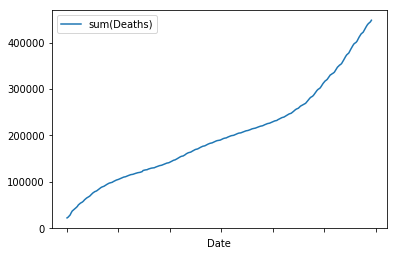

In [7]:
graph_data = pd.read_sql("SELECT sum(Deaths), Date FROM Covid_Data WHERE Date > '2020-04-12' GROUP BY Date;", engine)
graph_data.time = pd.to_datetime(graph_data['Date'], format='%Y-%m-%dT%H:%M:%S')
graph_data.set_index(['Date'], inplace=True)
graph_data.plot(rot=20)

Initial: 2590765 recovered: 826684.0


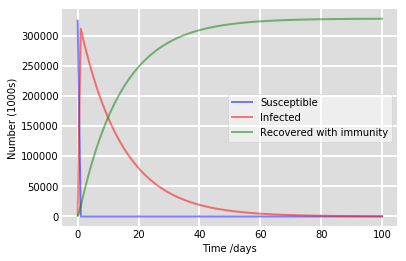

In [15]:
# SIR model
# The SIR model divides the population in 3 groups
# 1. S(t) are the ones which could get the virus
# 2. I(t) is the number of infected people
# 3. R(t) are the recovered and immune

# Total population, N.
N = 328200000
# Initial number of infected and recovered individuals, I0 and R0.
I0 = (engine.execute("SELECT SUM (D) FROM (SELECT MAX (Confirmed) AS D FROM Covid_Data WHERE Date > " + analysis_start_date +  " AND Date < " + analysis_end_date + " GROUP BY rtrim(Province_State));").fetchall())[0][0]
R0 = (engine.execute("SELECT SUM (D) FROM (SELECT MAX (Recovered) AS D FROM Covid_Data WHERE Date > " + analysis_start_date +  " AND Date < " + analysis_end_date + " GROUP BY rtrim(Province_State));").fetchall())[0][0]
print("Initial: " + str(I0) + " recovered: " + str(R0))
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 16, 1/14 
# A grid of time points (in days)
t = np.linspace(0, 100, 100)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()